In [1]:
# Import third-party packages.
from imblearn.over_sampling import RandomOverSampler
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, average_precision_score, classification_report, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
import warnings
from xgboost import XGBClassifier

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
warnings.filterwarnings('ignore')

In [2]:
# Read in preprocessed data on trees.
df = pd.read_csv('./data/data_preprocessed/features.csv') #, compression='gzip'

# Split into training, testing, and validation datasets

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12cbbdca0>,
      dtype=object)

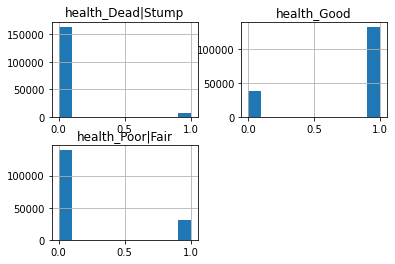

In [3]:
x = df.loc[:, 'steward_Alive':'n_neighbors_two or more neighbors']
y = df.loc[:, 'health_Dead|Stump':]

x_train, x_valid, y_train, y_valid = train_test_split(x,
                                                      y,
                                                      test_size=0.5,
                                                      random_state=34,
                                                      shuffle=True,
                                                      stratify=y)

x_training, x_testing, y_training, y_testing = train_test_split(x_train,
                                                                y_train,
                                                                test_size=0.5,
                                                                random_state=34,
                                                                shuffle=True,
                                                                stratify=y_train)

# Check class imbalance of targets.
y_training.hist()

# Oversampling

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b94fc10>,
      dtype=object)

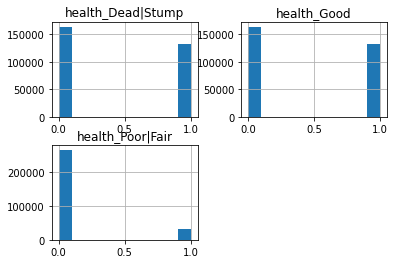

In [4]:
ros = RandomOverSampler(sampling_strategy='minority', random_state=34)

x_training_ros, y_training_ros = ros.fit_resample(x_training.values, y_training.values)

pd.DataFrame(y_training_ros, columns=df.columns[-3:]).hist()

# Modelling

In [5]:
# Enlist various classifiers with their default parameters.
classifiers = {
    'xgb': XGBClassifier(n_estimators=100,
                         objective='binary:logistic',
                         max_depth=8,
                         learning_rate=0.1,
                         verbosity=None,
                         booster=None,
                         tree_method=None,
                         gamma=1,
                         min_child_weight=None,
                         max_delta_step=None,
                         subsample=0.8,
                         colsample_bytree=None,
                         colsample_bylevel=None,
                         colsample_bynode=None,
                         reg_alpha=None,
                         reg_lambda=None,
                         scale_pos_weight=None,
                         base_score=None,
                         num_parallel_tree=None,
                         random_state=34,
                         n_jobs=-1,
                         monotone_constraints=None,
                         interaction_constraints=None,
                         importance_type='gain',
                         validate_parameters=None),
    'ada': AdaBoostClassifier(base_estimator=None,
                              n_estimators=50,
                              learning_rate=1.0,
                              random_state=34,
                              algorithm='SAMME.R'),
    'rdf': RandomForestClassifier(n_estimators=100,
                                  bootstrap=True,
                                  oob_score=False,
                                  n_jobs=-1,
                                  random_state=34,
                                  verbose=0,
                                  warm_start=False,
                                  class_weight=None,
                                  max_samples=None,
                                  criterion='gini',
                                  max_depth=None,
                                  min_samples_split=2,
                                  min_samples_leaf=1,
                                  min_weight_fraction_leaf=0.0,
                                  max_features='auto',
                                  max_leaf_nodes=None,
                                  min_impurity_decrease=0.0,
                                  min_impurity_split=None,
                                  ccp_alpha=0.0),
    'rid': RidgeClassifier(alpha=1.0,
                           fit_intercept=True,
                           normalize=False,
                           copy_X=True,
                           max_iter=None,
                           tol=0.001,
                           solver='auto',
                           random_state=34,
                           class_weight=None),
    'mlp': MLPClassifier(activation='relu',
                         solver='adam',
                         alpha=0.0001,
                         batch_size='auto',
                         learning_rate='constant',
                         learning_rate_init=0.001,
                         power_t=0.5,
                         max_iter=200,
                         hidden_layer_sizes=(100,),
                         shuffle=True,
                         random_state=34,
                         tol=0.0001,
                         verbose=False,
                         warm_start=False,
                         momentum=0.9,
                         nesterovs_momentum=True,
                         early_stopping=True,
                         validation_fraction=0.1,
                         beta_1=0.9,
                         beta_2=0.999,
                         epsilon=1e-08,
                         n_iter_no_change=10,
                         max_fun=15000),
    'svc': LinearSVC(dual=True,
                     tol=0.0001,
                     C=1.0,
                     multi_class='ovr',
                     fit_intercept=True,
                     intercept_scaling=1,
                     class_weight=None,
                     verbose=0,
                     random_state=34,
                     max_iter=1000,
                     penalty='l2',
                     loss='squared_hinge'),
    'lgbm': LGBMClassifier(boosting_type='gbdt',
                           objective=None,
                           num_leaves=31,
                           max_depth=-1,
                           learning_rate=0.1,
                           n_estimators=100,
                           subsample_for_bin=200000,
                           min_split_gain=0.0,
                           min_child_weight=0.001,
                           min_child_samples=20,
                           subsample=1.0,
                           subsample_freq=0,
                           colsample_bytree=1.0,
                           reg_alpha=0.0,
                           reg_lambda=0.0,
                           random_state=34,
                           n_jobs=-1,
                           silent=True,
                           importance_type='split')
    }

In [14]:
# Train, predict, and evaluate the default classifiers.
models = {}

for each, clf in classifiers.items():
    models[each] = {
            'trained_clf': MultiOutputClassifier(clf).fit(x_training_ros,
                                                          y_training_ros)
            }
    models[each]['y_pred'] = models[each]['trained_clf'].predict(x_testing)
    models[each]['accuracy'] = accuracy_score(y_testing.values,
                                              models[each]['y_pred'])
    models[each]['avg_prsc'] = average_precision_score(y_testing.values,
                                                       models[each]['y_pred'],
                                                       average='weighted')
    models[each]['clf_repo'] = classification_report(y_testing.values,
                                                     models[each]['y_pred'],
                                                     target_names=y.columns)
    
    print(each, 'accuaracy: ', models[each]['accuracy'])
    print(each, 'average precision score: ', models[each]['avg_prsc'])
    print(models[each]['clf_repo'])

xgb accuaracy:  0.8213071887778083
xgb average precision score:  0.7140848820164488
                   precision    recall  f1-score   support

health_Dead|Stump       1.00      1.00      1.00      7904
      health_Good       0.82      0.99      0.90    132213
 health_Poor|Fair       0.55      0.05      0.09     30830

        micro avg       0.82      0.82      0.82    170947
        macro avg       0.79      0.68      0.66    170947
     weighted avg       0.78      0.82      0.76    170947
      samples avg       0.82      0.82      0.82    170947

ada accuaracy:  0.8215762780276928
ada average precision score:  0.7120247097132393
                   precision    recall  f1-score   support

health_Dead|Stump       1.00      1.00      1.00      7904
      health_Good       0.82      0.99      0.90    132213
 health_Poor|Fair       0.59      0.04      0.07     30830

        micro avg       0.82      0.82      0.82    170947
        macro avg       0.80      0.68      0.65    170947
 

# Hyperparameter optimization

In [6]:
def hypertune(model, parameters, gridsearch_clfs, allthemodels=classifiers, x_tr=x_training_ros, y_tr=y_training_ros):
    """
    Performs hyperparameter optimization for all of the given models, updates their default parameters with the
    best parameters after the optimization, and returns the result in a dictionary.
    
    :param model: str. Name of the algorithm to be tuned.
    :param parameters: dict. Dictionary with desired variants of hyperparameters for tuning.
    :param gridsearch_clfs: dict. Dictionary which should hold the output afterwards.
    :param allthemodels: dict. Dictionary with all pre-trained models.
    :param x_tr: numpy.ndarray. Training dataset of the features.
    :param y_tr: numpy.ndarray. Training dataset of the targets.
    
    :return: None
    """
    
    score_metric = make_scorer(f1_score, average='weighted')
    
    print('######### START HYPERPARAMETER TUNING FOR MODEL:', model, '###########################')

    gridsearch_clfs[model] = {
                        'grid_classifier': GridSearchCV(MultiOutputClassifier(allthemodels[model]),
                                                        param_grid=parameter_grid,
                                                        cv=2, # try ShuffleSplit..
                                                        scoring=score_metric,
                                                        refit=True,
                                                        verbose=0,
                                                        error_score=0,
                                                        return_train_score=False,
                                                        n_jobs=-1) \
                                          .fit(x_training_ros,
                                               y_training_ros)
                        }

    gridsearch_clfs[model]['f1_score'] = gridsearch_clfs[model]['grid_classifier'].best_score_
    print('Best F1 score: ', gridsearch_clfs[model]['f1_score'])
    
    gridsearch_clfs[model]['best_parameters'] = gridsearch_clfs[model]['grid_classifier'].best_params_
    gridsearch_clfs[model]['best_parameters'] = {i.replace('estimator__',''): v
                                                 for i, v in gridsearch_clfs[model]['best_parameters'] \
                                                .items()}

    # Return & update the set of default parameters.
    for every, param in gridsearch_clfs[model]['best_parameters'].items():
        allthemodels[model].__dict__[every] = gridsearch_clfs[model]['best_parameters'][every] 

    print('Updated parameter setting: ')
    print(allthemodels[model])
    
    print('######### FINISH #####################################################################', '\n')

### LGBMClassifier

In [68]:
gridsearch_rdf = {}

parameter_grid = {
       'estimator__criterion': ['entropy'],
       'estimator__max_features': ['log2'],
       'estimator__n_estimators': [35]
       }

hypertune('rdf', parameter_grid, gridsearch_rdf)

######### START HYPERPARAMETER TUNING FOR MODEL: rdf ###########################
Best F1 score:  0.8568421403101456
Updated parameter setting: 
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=35, n_jobs=-1,
                       oob_score=False, random_state=34, verbose=0,
                       warm_start=False)
######### FINISH ##################################################################### 



-- 04.06.2020 --

######### START HYPERPARAMETER TUNING FOR MODEL: rdf ###########################
Best F1 score:  0.8568421403101456
Updated parameter setting: 
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=35, n_jobs=-1,
                       oob_score=False, random_state=34, verbose=0,
                       warm_start=False)
######### FINISH ##################################################################### 

In [7]:
gridsearch_lgbm = {}

parameter_grid = {
       'estimator__boosting_type': ['dart'],
       'estimator__num_leaves': [140],
       'estimator__learning_rate': [1.0],
       'estimator__n_estimators': [95],
       'estimator__reg_lambda': [2.0],
       'estimator__subsample': [0.1],
       'estimator__min_child_weight': [0.00001],
       'estimator__subsample_for_bin': [50000]
       }

hypertune('lgbm', parameter_grid, gridsearch_lgbm)

######### START HYPERPARAMETER TUNING FOR MODEL: lgbm ###########################
Best F1 score:  0.8776526203422736
Updated parameter setting: 
LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=1.0, max_depth=-1,
               min_child_samples=20, min_child_weight=1e-05, min_split_gain=0.0,
               n_estimators=95, n_jobs=-1, num_leaves=140, objective=None,
               random_state=34, reg_alpha=0.0, reg_lambda=2.0, silent=True,
               subsample=0.1, subsample_for_bin=50000, subsample_freq=0)
######### FINISH ##################################################################### 



-- 04.06.2020 --

######### START HYPERPARAMETER TUNING FOR MODEL: lgbm ###########################
Best F1 score:  0.8776526203422736
Updated parameter setting: 
LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=1.0, max_depth=-1,
               min_child_samples=20, min_child_weight=1e-05, min_split_gain=0.0,
               n_estimators=95, n_jobs=-1, num_leaves=140, objective=None,
               random_state=34, reg_alpha=0.0, reg_lambda=2.0, silent=True,
               subsample=0.1, subsample_for_bin=50000, subsample_freq=0)
######### FINISH ##################################################################### 

# Testing with optimized hyperparameters

### LGBMClassifier

In [69]:
tuned_classifier = MultiOutputClassifier(classifiers['lgbm']).fit(x_training_ros, y_training_ros)
y_pred = tuned_classifier.predict(x_valid.values)
accuracy = accuracy_score(y_valid.values,
                          y_pred)
f1 = f1_score(y_valid,
              y_pred,
              average='weighted')
clf_report = classification_report(y_valid.values,
                                   y_pred,
                                   target_names=y.columns)

print("Accuracy: ", accuracy)
print("F1 score: ", f1)
print(clf_report)

Accuracy:  0.8095023603807028
F1 score:  0.7530120560658087
                   precision    recall  f1-score   support

health_Dead|Stump       1.00      1.00      1.00     15808
      health_Good       0.82      0.99      0.90    264425
 health_Poor|Fair       0.43      0.04      0.08     61661

        micro avg       0.82      0.82      0.82    341894
        macro avg       0.75      0.68      0.66    341894
     weighted avg       0.76      0.82      0.75    341894
      samples avg       0.81      0.82      0.82    341894



# Save / load current status

In [72]:
with open('rdf_clf.pkl', 'wb') as handle:
    pickle.dump(gridsearch_rdf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('gridsearch_lgbm_clfs.pkl', 'rb') as handle:
    gridsearch_lgbm = pickle.load(handle)